In [244]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [245]:
df = pd.read_csv('Global_monthly_mean_ch4.csv',index_col='date')
df.index = pd.to_datetime(df.index)
df=df.drop('year',axis=1)
df=df.drop('month',axis=1)
df.head()

,average
date,
1983-07-01,1626.58
1983-08-01,1627.88
1983-09-01,1638.49
1983-10-01,1644.80
1983-11-01,1642.58


<AxesSubplot:xlabel='date'>

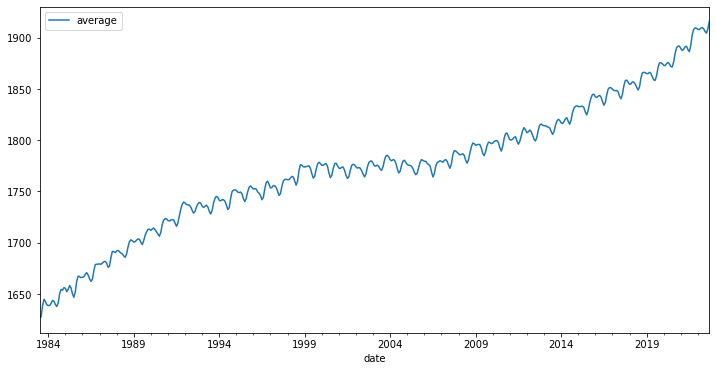

In [246]:
df.plot(figsize=(12,6))

In [247]:
len(df)
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,test_size=0.2,shuffle=False)

In [248]:
#train = df.iloc[:350]
#test = df.iloc[350:]
print(train.head())
print(test.head())

            average
date               
1983-07-01  1626.58
1983-08-01  1627.88
1983-09-01  1638.49
1983-10-01  1644.80
1983-11-01  1642.58
            average
date               
2014-11-01  1833.07
2014-12-01  1833.54
2015-01-01  1832.89
2015-02-01  1832.68
2015-03-01  1833.04


In [249]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [250]:
df.head(),df.tail()

(            average
 date               
 1983-07-01  1626.58
 1983-08-01  1627.88
 1983-09-01  1638.49
 1983-10-01  1644.80
 1983-11-01  1642.58,
             average
 date               
 2022-05-01  1908.67
 2022-06-01  1906.11
 2022-07-01  1904.52
 2022-08-01  1908.61
 2022-09-01  1915.86)

In [251]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [252]:
scaled_train[:10]

array([[0.        ],
       [0.00635169],
       [0.05819123],
       [0.08902135],
       [0.07817462],
       [0.06322373],
       [0.0590707 ],
       [0.05955929],
       [0.06928226],
       [0.08374456]])

In [253]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [254]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [255]:

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.00635169 0.05819123]
Predict this y: 
 [[0.08902135]]


In [256]:
X.shape

(1, 3, 1)

In [257]:
n_input = 14
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [258]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [259]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [260]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [261]:
# fit model
model.fit(generator,epochs=50,verbose=1)

Epoch 1/50
362/362 [==============================] - 6s 10ms/step - loss: 0.0130
Epoch 2/50
362/362 [==============================] - 3s 10ms/step - loss: 0.0012
Epoch 3/50
362/362 [==============================] - 3s 10ms/step - loss: 0.0013
Epoch 4/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 5/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 6/50
362/362 [==============================] - 4s 10ms/step - loss: 8.2983e-04
Epoch 7/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0010
Epoch 8/50
362/362 [==============================] - 4s 10ms/step - loss: 8.6916e-04
Epoch 9/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 10/50
362/362 [==============================] - 3s 10ms/step - loss: 8.9746e-04
Epoch 11/50
362/362 [==============================] - 3s 10ms/step - loss: 0.0013
Epoch 12/50
362/362 [==============================] - 3s 10ms/step - loss: 8.9304e-

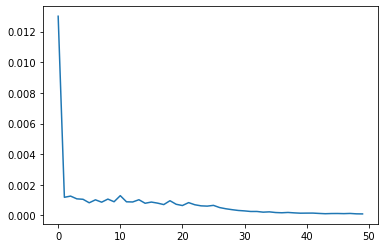

In [262]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [263]:
last_train_batch = scaled_train[-n_input:]


In [264]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [265]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 353ms/step


array([[1.0079782]], dtype=float32)

In [266]:
scaled_test[0]

array([1.00889236])

In [267]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [268]:
test_predictions

[array([1.0079782], dtype=float32),
 array([1.0079062], dtype=float32),
 array([1.0013136], dtype=float32),
 array([0.99541295], dtype=float32),
 array([0.9946078], dtype=float32),
 array([0.997981], dtype=float32),
 array([1.0002635], dtype=float32),
 array([0.99644506], dtype=float32),
 array([0.9920179], dtype=float32),
 array([1.0024428], dtype=float32),
 array([1.0243503], dtype=float32),
 array([1.044391], dtype=float32),
 array([1.057878], dtype=float32),
 array([1.0658277], dtype=float32),
 array([1.0678867], dtype=float32),
 array([1.0657438], dtype=float32),
 array([1.0630383], dtype=float32),
 array([1.0617937], dtype=float32),
 array([1.0613675], dtype=float32),
 array([1.0601311], dtype=float32),
 array([1.0598997], dtype=float32),
 array([1.0672917], dtype=float32),
 array([1.0828212], dtype=float32),
 array([1.0999368], dtype=float32),
 array([1.1144971], dtype=float32),
 array([1.1258416], dtype=float32),
 array([1.1340622], dtype=float32),
 array([1.139312], dtype=floa

In [269]:
test.head()

,average
date,
2014-11-01,1833.07
2014-12-01,1833.54
2015-01-01,1832.89
2015-02-01,1832.68
2015-03-01,1833.04


In [270]:
true_predictions = scaler.inverse_transform(test_predictions)

In [271]:
test['Predictions'] = true_predictions
print(true_predictions)

[[1832.88289838]
 [1832.86816165]
 [1831.51884779]
 [1830.31116761]
 [1830.1463797 ]
 [1830.8367737 ]
 [1831.30392083]
 [1830.52241038]
 [1829.61630867]
 [1831.7499754 ]
 [1836.23377294]
 [1840.33551335]
 [1843.09589383]
 [1844.72296095]
 [1845.14437297]
 [1844.70578436]
 [1844.15205892]
 [1843.8973135 ]
 [1843.81008863]
 [1843.55702671]
 [1843.5096691 ]
 [1845.02259973]
 [1848.20102523]
 [1851.70407364]
 [1854.6841144 ]
 [1857.00600387]
 [1858.68850453]
 [1859.76299295]
 [1860.35868392]
 [1860.5579958 ]
 [1860.49592585]
 [1860.33904308]
 [1860.4509593 ]
 [1861.61281898]
 [1863.89669548]
 [1866.62279598]
 [1869.27987293]
 [1871.68908486]
 [1873.79082607]
 [1875.57904572]
 [1877.07438499]
 [1878.30419467]
 [1879.30978154]
 [1880.17473508]
 [1881.05515731]
 [1882.19857167]
 [1883.78147739]
 [1885.72760456]
 [1887.82583237]
 [1889.92157154]
 [1891.94338305]
 [1893.8659412 ]
 [1895.67975494]
 [1897.37572361]
 [1898.95374962]
 [1900.43586487]
 [1901.87445307]
 [1903.3518106 ]
 [1904.9493798

C:\Users\Ritvik\AppData\Local\Temp/ipykernel_9792/844688957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

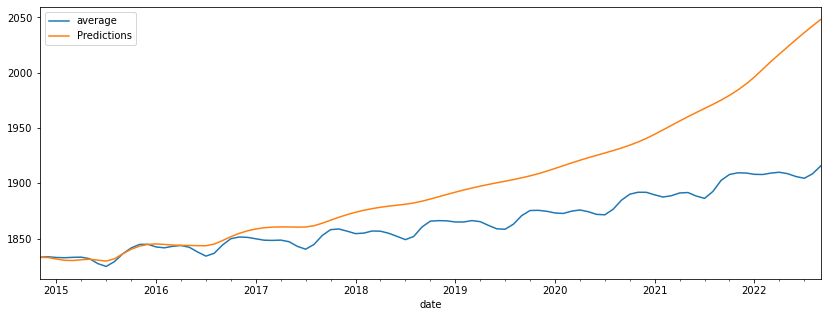

In [272]:
test.plot(figsize=(14,5))

In [273]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(test['average'],test['Predictions'])))

49.38751180421439
